# Packages and functions

In [ ]:
!pip install quantecon
!pip install YahooFinancials
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.4/215.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for YahooFinancials: filename=yahoofinancials-1.20-py3-none-any.whl size=38617 sha256=c36bdbdbee884b12661dc300d72ab2014a61c06e4013e1a1b92753fd5e893f3c
  Stored in directory: /root/.cache/pip/wheels/cc/6b/dd/7ff776de4ebf7b144bb9562a813be59d0108306f368af9b637
Successfully built YahooFinancials
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 7.7 MB/s eta 0:00:00


In [ ]:
import warnings
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels
import arch
import  matplotlib.pylab as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.style.use('fivethirtyeight')
from pathlib import Path
from arch.unitroot import ADF, DFGLS, PhillipsPerron, KPSS
from yahoofinancials import YahooFinancials
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from arch.unitroot import ADF
from arch.unitroot import DFGLS
from arch.unitroot import PhillipsPerron
from arch.unitroot import KPSS

In [ ]:
def retrieve_stock_data(ticker, start, end):
    json = YahooFinancials(ticker).get_historical_price_data(start, end, 'daily')
    df = pd.DataFrame(columns=['open','close','adjclose'])
    for row in json[ticker]['prices']:
        date = datetime.fromisoformat(row['formatted_date'])
        df.loc[date] = [row['open'], row['close'], row['adjclose']]
    df.index.name = "date"
    return df

# Topic introduction

In the global energy landscape, the oil refining sector remains a critical component, influencing not only national economies but also geopolitics and environmental policies. Tüpraş, acronym for Türkiye Petrol Rafinerileri A.Ş., is the largest refining company in Turkey and plays a central role in the country’s energy industry. Founded in 1983 through the privatization of state-owned refineries, Tüpraş has expanded its operations and today operates four refineries in Turkey with significant overall capacity.

This project focuses on the analysis of the historical series of adjusted closing prices of Tüpraş shares from 2022-04-22 to today, with the aim of identifying the best model for predicting future values. Adjusted closing prices are particularly valuable for the analysis as they reflect the real value of the share, adjusted for all effects of dividend distributions and extraordinary transactions, thus providing a more accurate and consistent representation of the company’s historical performance.

# Data Collection

In [ ]:
data = retrieve_stock_data("TUPRS.IS", "2022-04-22", "2024-04-22") # Takes data directly from yahooFinance
data = data['adjclose'] # Series of the adjusted closing prices
data

date
2022-04-22     30.261398
2022-04-25     30.904751
2022-04-26     29.189144
2022-04-27     29.248714
2022-04-28     28.355169
                 ...    
2024-04-15    183.000000
2024-04-16    186.000000
2024-04-17    186.500000
2024-04-18    185.899994
2024-04-19    189.899994
Name: adjclose, Length: 498, dtype: float64

# Exploratory Data Analysis

In [ ]:
# Statistical descriptions
data = data.dropna() # delete "NaN" values
data.describe()

count    497.000000
mean      85.089607
std       45.602997
min       27.139950
25%       44.415157
50%       69.667610
75%      133.051178
max      189.899994
Name: adjclose, dtype: float64

The series consists of 497 observations. This number reflects the amount of daily data collected for analysis, indicating a sufficiently long observation period to provide robust statistical results. Prices fluctuated between a minimum of 27.14 and a maximum of 189.90 and the average adjusted closing price of the shares is about 85.01. The standard deviation is 45.60, a relatively high value indicating significant volatility in Tüpraş stock prices over time. This volatility can be influenced by a variety of factors, including changes in the energy sector, oil price fluctuations, and general economic dynamics.  The median is 69.67, which means that half of the prices are below this value and the other half above.

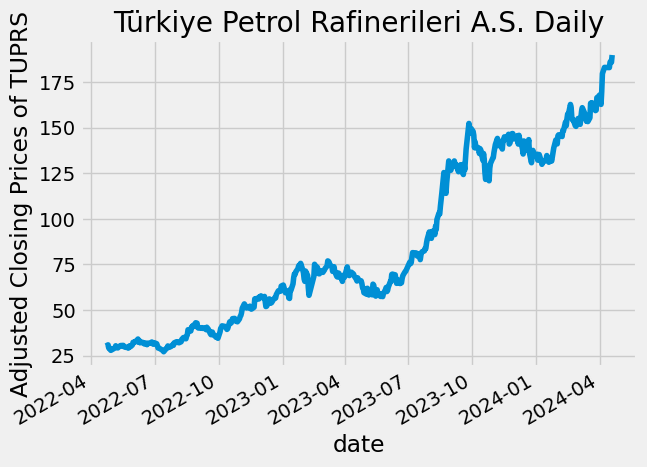

In [ ]:
# Data plot
data.plot(); plt.title("Türkiye Petrol Rafinerileri A.S. Daily");plt.ylabel("Adjusted Closing Prices of TUPRS")
plt.show()

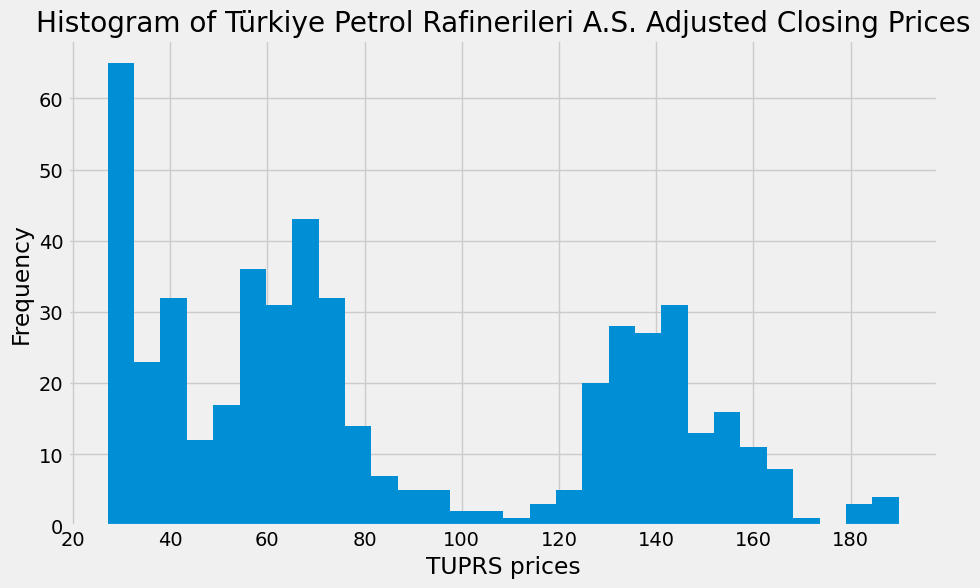

In [ ]:
# Hystogram
plt.figure(figsize=(10, 6))
data.hist(bins=30)
plt.title('Histogram of Türkiye Petrol Rafinerileri A.S. Adjusted Closing Prices')
plt.xlabel('TUPRS prices')
plt.ylabel('Frequency')
plt.show()

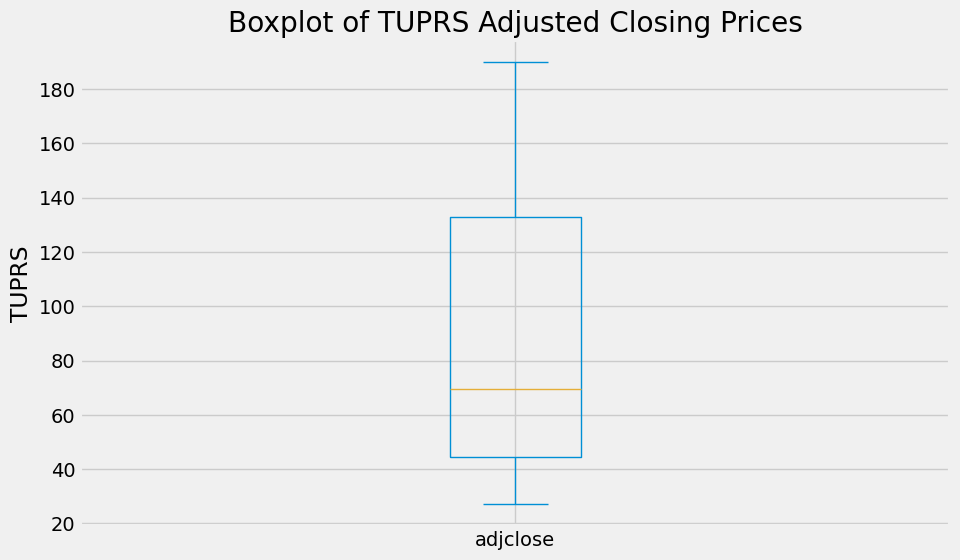

In [ ]:
# Boxplot
plt.figure(figsize=(10, 6))
data.plot(kind='box')
plt.title('Boxplot of TUPRS Adjusted Closing Prices')
plt.ylabel('TUPRS')
plt.show()

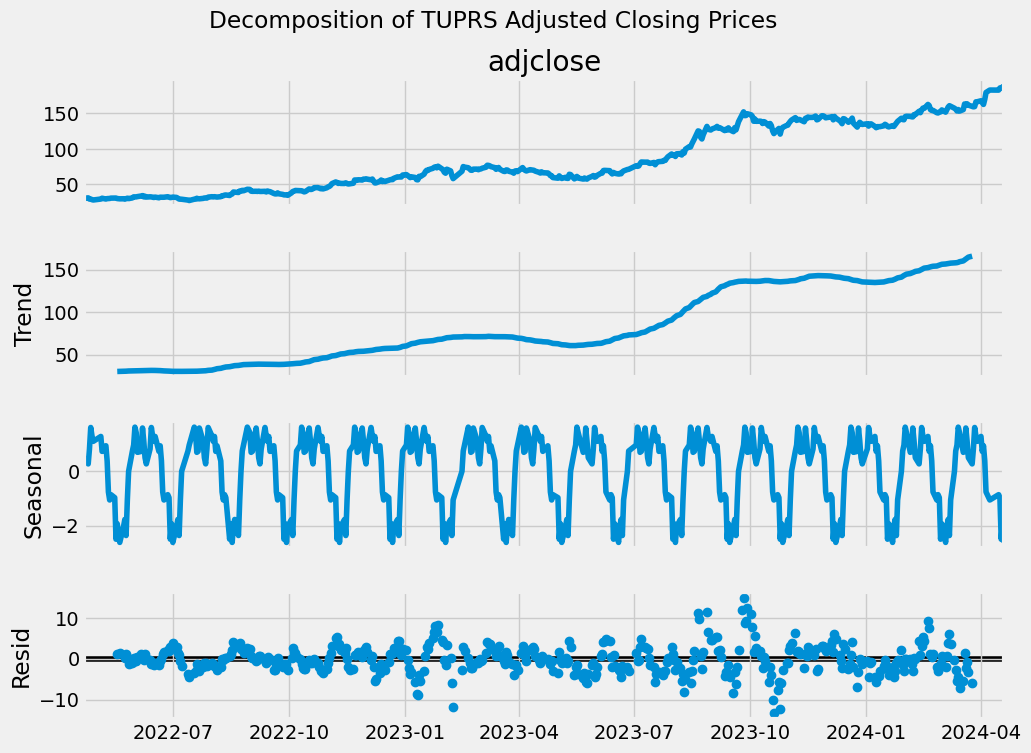

In [ ]:
# Trend and seasonality components
data.dropna(inplace=True)
decomposition = seasonal_decompose(data, model='additive', period=30)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
fig.suptitle('Decomposition of TUPRS Adjusted Closing Prices')
plt.show()

# Stationarity Check

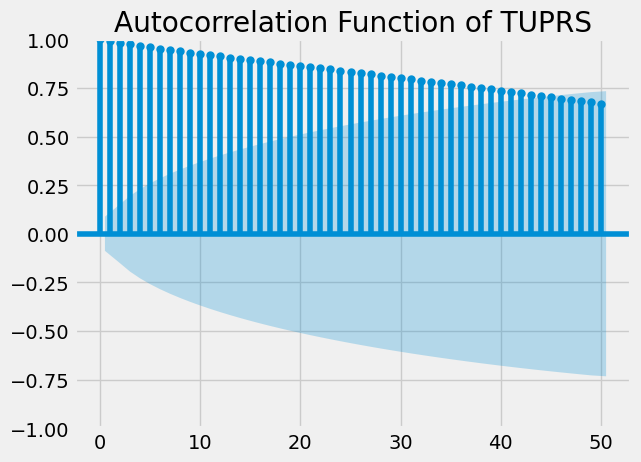

In [ ]:
# Autocorrelation function
data_acf=plot_acf(data, lags=50); plt.title("Autocorrelation Function of TUPRS")
plt.show()

For a stationary series, we expect autocorrelations between series values to quickly decay to zero. This indicates that future values of the series are not significantly dependent on past values.
According to the above, the TUPRS series is not stationary

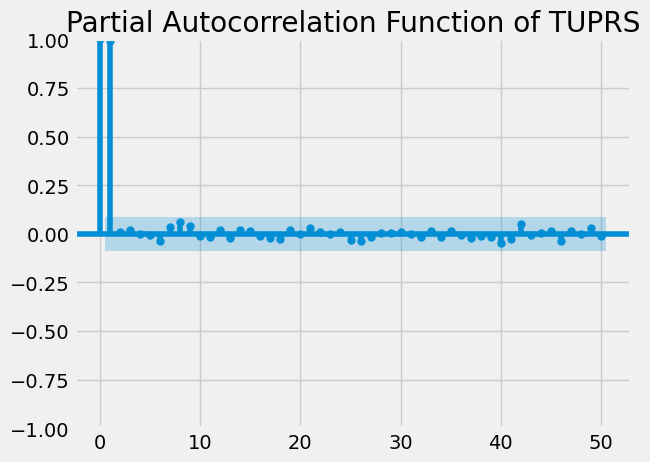

In [ ]:
# Partial autocorrelation function
data_pacf=plot_pacf(data, lags=50); plt.title("Partial Autocorrelation Function of TUPRS")
plt.show()

The PACF shows the correlations between the series to a given delay, controlling the effects of all shorter delays, then a quickly decay is expected, for the series to be stationary.
Also for the partial autocorrelation graph, the series seems to be non-stationary.

We can make the first difference of the series and see if the new obtained series is stationary.

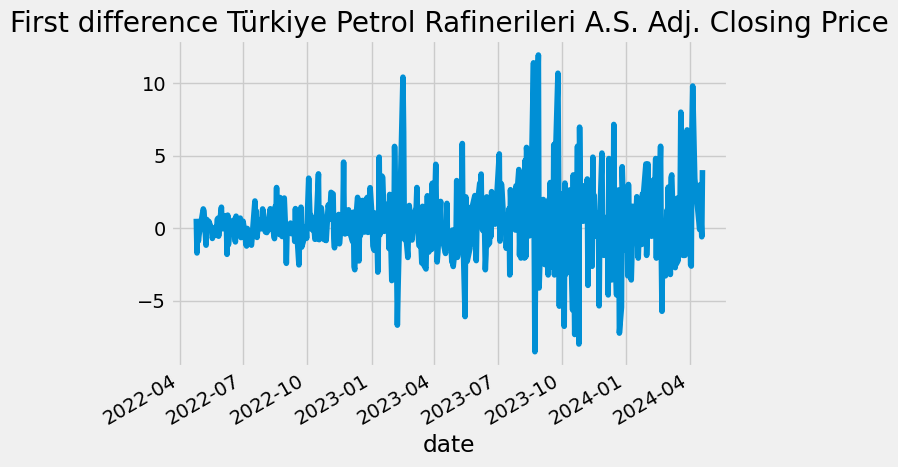

date
2022-04-25    0.643353
2022-04-26   -1.715607
2022-04-27    0.059570
2022-04-28   -0.893545
2022-04-29   -0.452730
                ...   
2024-04-15   -0.100006
2024-04-16    3.000000
2024-04-17    0.500000
2024-04-18   -0.600006
2024-04-19    4.000000
Name: adjclose, Length: 496, dtype: float64

In [ ]:
# First difference
dif_data = data.diff(1).dropna()
dif_data.plot(); plt.title("First difference Türkiye Petrol Rafinerileri A.S. Adj. Closing Price");
plt.show()
dif_data.dropna()

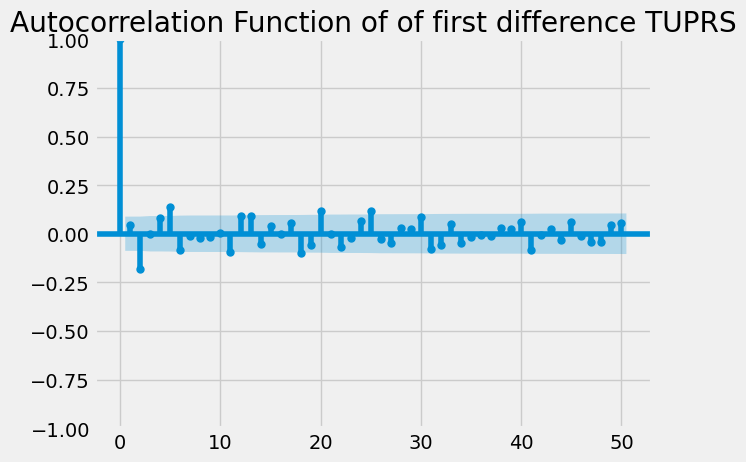

In [ ]:
# Fist difference
# Autocorrelation function
dif_data_acf=plot_acf(dif_data, lags=50); plt.title("Autocorrelation Function of of first difference TUPRS")
plt.show()

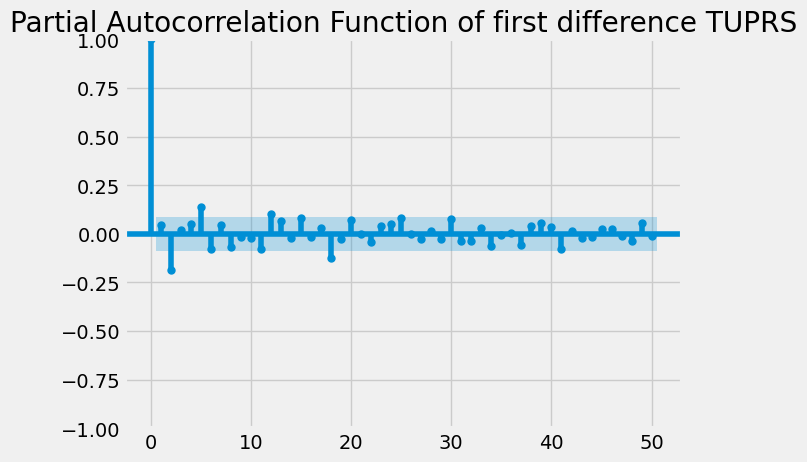

In [ ]:
# Partial autocorrelation function
dif_pacf=plot_pacf(dif_data, lags=50); plt.title("Partial Autocorrelation Function of first difference TUPRS")
plt.show()

In this case, both from the autocorrelation plot and from the partial autocorrelation plot it would seem that the series of the first differences is stationary (the original series would be said difference stationariy).

# Formal Test for Stationarity

However, tests should be used to verify the series stationarity. Following are runned the Augmented Dickey Fuller Test, the KPSS test, the Phillips-Perron test and the DF-GLS test respectively.

Rule of thumb is used to decide whether a series is stationary or not: if the test statistic is less than the critical value, the series is stationary.

## Augmented Dickey Fuller Test


In [ ]:
# For TUPRS
adf_data = ADF(data, trend='ct', max_lags=20)  # max_lags since it is not taking into account seriel correlation
adf_data

Test Statistic,-1.667
P-value,0.765
Lags,18


The t-statistic is more than all the critical values: the serie is non-stationary.

In [ ]:
# For First difference of TUPRS
dif_adf_data = ADF(dif_data, trend='ct', max_lags=10)
dif_adf_data

Test Statistic,-8.812
P-value,0.000
Lags,5


The t-statistic is less than all the critical values: the first difference serie is stationary.

## KPSS test

In [ ]:
# For TUPRS
kpss_data = KPSS(data, trend='ct')  # KPSS takes into account serial autocorrelation
kpss_data

Test Statistic,0.463
P-value,0.000
Lags,12


The t-statistic is more than all the critical values: the serie is non-stationary.

In [ ]:
# For First difference of TUPRS
dif_kpss_data=KPSS(dif_data, trend='ct')
dif_kpss_data

Test Statistic,0.052
P-value,0.554
Lags,9


The t-statistic is less than all the critical values: the first difference serie is stationary.

## Phillips–Perron test

In [ ]:
# For TUPRS
PhillipsPerron_data = PhillipsPerron (data, trend='ct')
PhillipsPerron_data

Test Statistic,-1.794
P-value,0.708
Lags,18


The t-statistic is more than all the critical values: the serie is non-stationary.

In [ ]:
# For First difference of TUPRS
dif_PhillipsPerron_data= PhillipsPerron (dif_data, trend='ct')
dif_PhillipsPerron_data

Test Statistic,-21.213
P-value,0.000
Lags,18


The t-statistic is less than all the critical values: the first difference serie is stationary.

## DFGLS (Dickey-Fuller Generalized Least Squares ) Test for TUPRS

In [ ]:
# For TUPRS
DFGLS_data = DFGLS(data, trend='ct', max_lags=10)
DFGLS_data

Test Statistic,-1.161
P-value,0.765
Lags,6


The t-statistic is more than all the critical values: the serie is non-stationary.

In [ ]:
# For First difference of TUPRS
dif_DFGLS_data = DFGLS(dif_data, trend='ct', max_lags=10)
dif_DFGLS_data

Test Statistic,-7.867
P-value,0.000
Lags,5


The t-statistic is less than all the critical values: the first difference serie is stationary.

To confirm what was possible to guess from the autocorrelation and partial autocorrelation plots, all tests show that the original series is not stationary while the first difference series is.
The order of integration of the original series is, therefore, 1 (I(1)).

# Data division

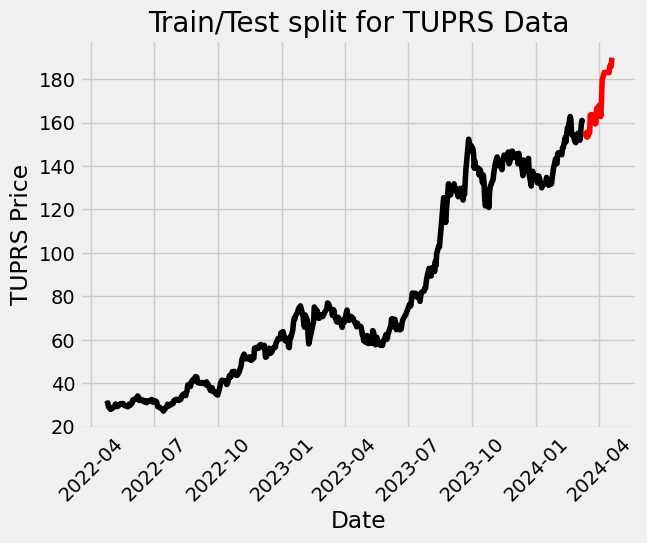

In [ ]:
train = data[data.index < pd.to_datetime("2024-03-11", format='%Y-%m-%d')]
test = data[data.index > pd.to_datetime("2024-03-11", format='%Y-%m-%d')]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('TUPRS Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for TUPRS Data")
plt.show()

y = train

Data division is a fundamental part of preparing a time series dataset for predictive modeling, ensuring that the model is trained on past data and tested on future, unseen data to mimic real-world forecasting scenarios.

# Models

Different models will be evaluated in this section: AR(1), AR(2), MA(1), ARIMA(1,1,1), ARIMA(2,1,2) and ARIMA(3,1,2).

For each model a diagnostic test is carried out, the two informative criteria AIC and BIC are highlighted and an in-sample forecast takes place.

To do this we use the SARIMAX function with integration level 1, since we have seen that the series is difference stationary ( first difference series is stationary).

## Model 1

In [ ]:
# AR(1) model
mod1=sm.tsa.statespace.SARIMAX(y,trend='c',order=(1,1,0))
results=mod1.fit(disp=False)
print(results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               adjclose   No. Observations:                  471
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1096.622
Date:                Wed, 24 Apr 2024   AIC                           2199.245
Time:                        15:46:49   BIC                           2211.703
Sample:                             0   HQIC                          2204.146
                                - 471                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2684      0.118      2.272      0.023       0.037       0.500
ar.L1          0.0286      0.032      0.893      0.372      -0.034       0.091
sigma2         6.2250      0.262     23.743      0.0

2199.244552092297
2211.702750176409


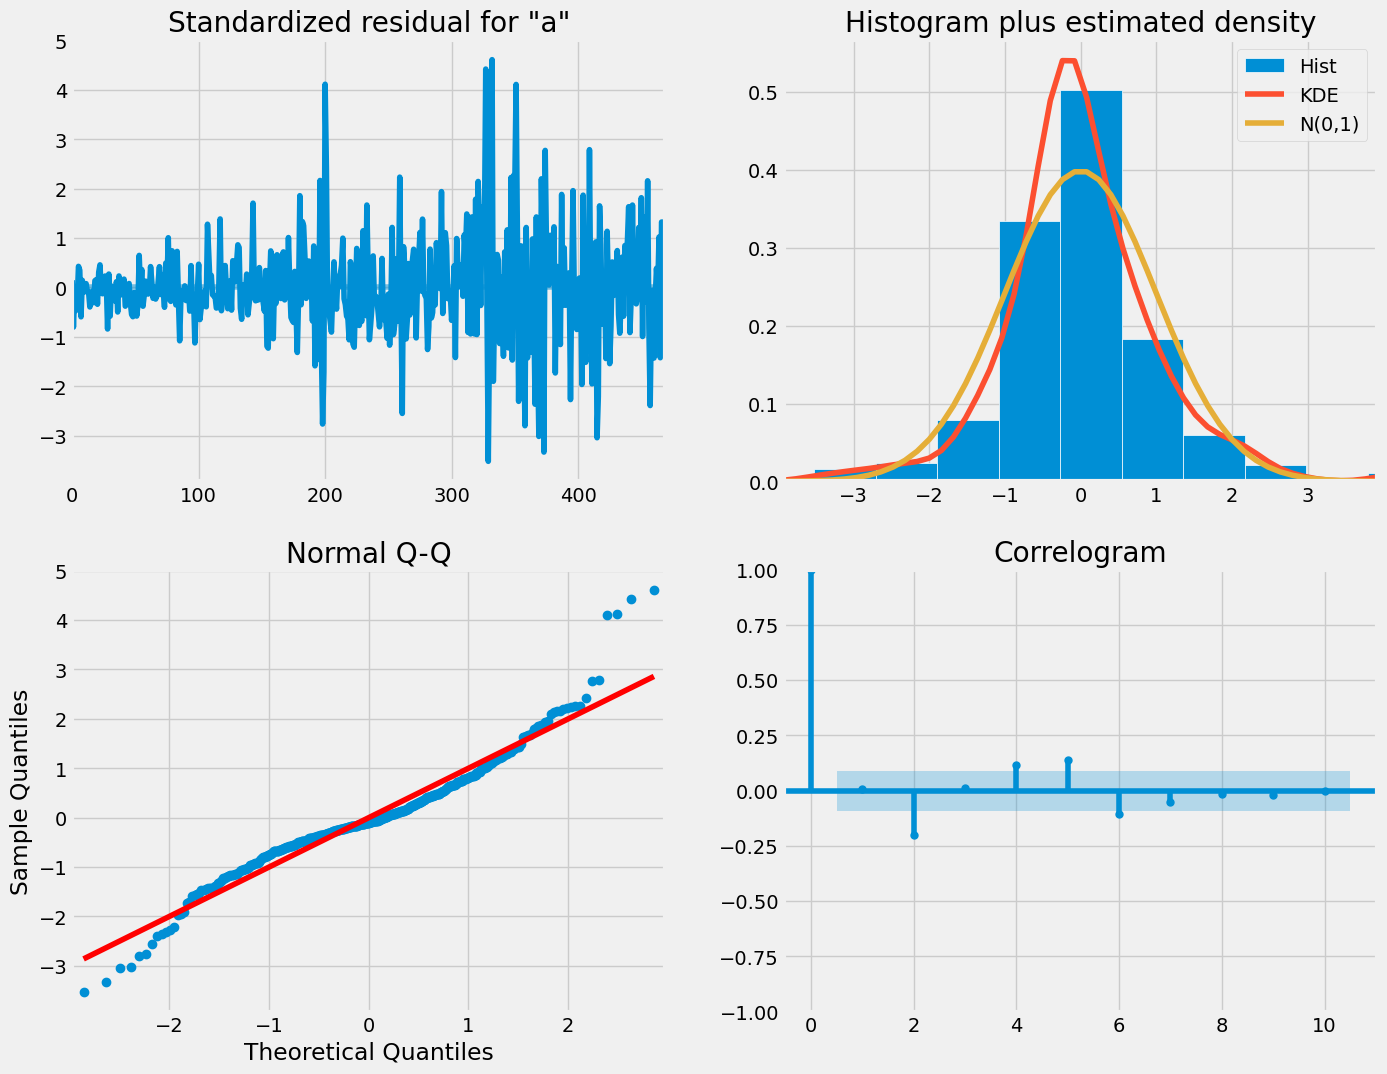

In [ ]:
# Residuals diagnostic
residuals=results.resid
results.plot_diagnostics(figsize=(15,12))

# Information criterias
mod_aic = results.aic
print(mod_aic)
mod_bic = results.bic
print(mod_bic)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


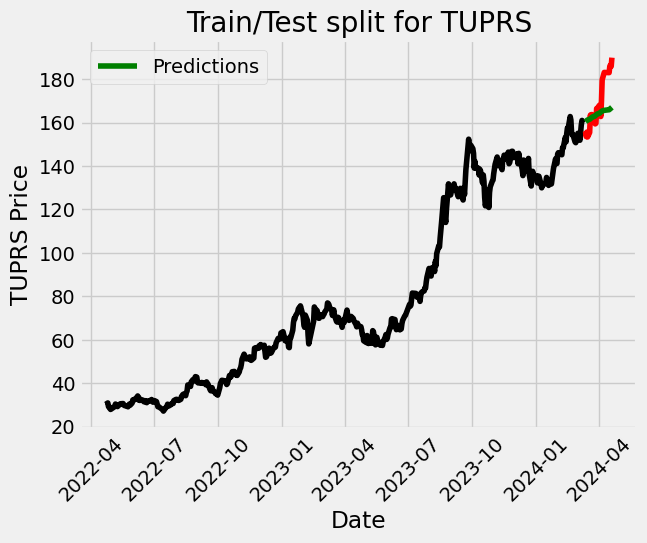

In [ ]:
# Forecast
y_pred = results.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df["Predictions"] = results.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

# Plot combined
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('TUPRS Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for TUPRS")
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()
plt.show()


# Forecast performance
mae1=abs(test-y_pred_out).mean()
mape1=100*(abs(test-y_pred_out)/test).mean()
rmse = np.mean((y_pred_out - test)**2)**.5

## Model 2

In [ ]:
# AR(2) model
mod2 = sm.tsa.statespace.SARIMAX(y, order = (2, 1, 0))
results2 = mod2.fit(disp=False)
print(results2.summary())

                               SARIMAX Results                                
Dep. Variable:               adjclose   No. Observations:                  471
Model:               SARIMAX(2, 1, 0)   Log Likelihood               -1091.080
Date:                Wed, 24 Apr 2024   AIC                           2188.160
Time:                        15:46:54   BIC                           2200.618
Sample:                             0   HQIC                          2193.062
                                - 471                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0480      0.032      1.490      0.136      -0.015       0.111
ar.L2         -0.1852      0.030     -6.161      0.000      -0.244      -0.126
sigma2         6.0793      0.249     24.392      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


2188.160189595939
2200.618387680051


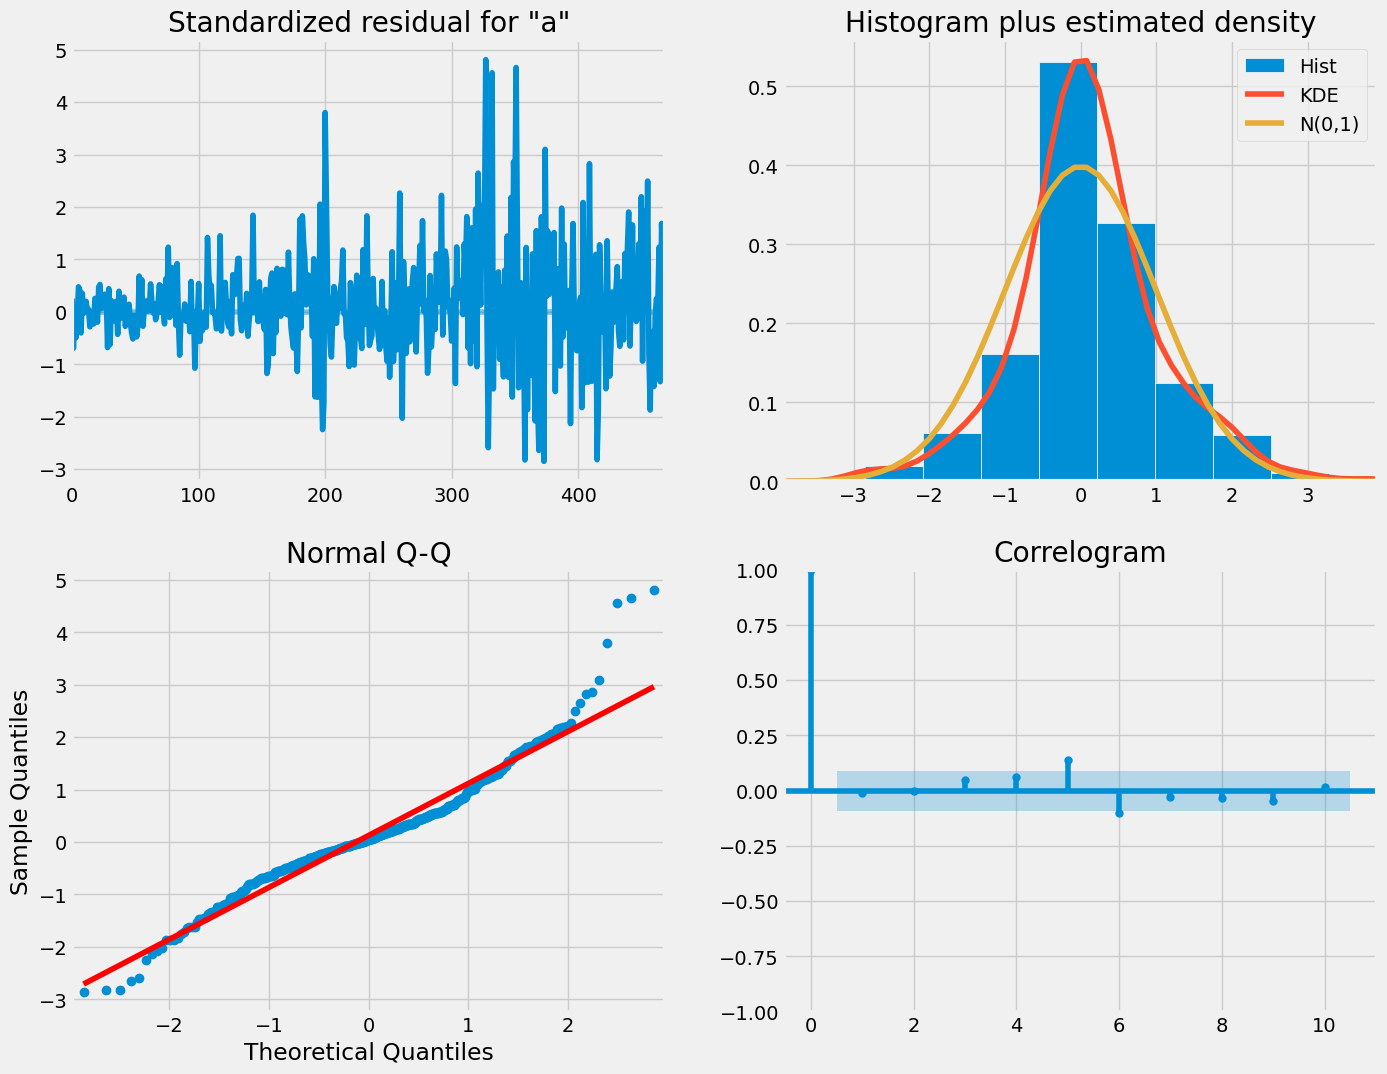

In [ ]:
# Residuals diagnostic
residuals2=results2.resid
results2.plot_diagnostics(figsize=(15,12))

# Information criterias
mod_aic2 = results2.aic
print(mod_aic2)
mod_bic2 = results2.bic
print(mod_bic2)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


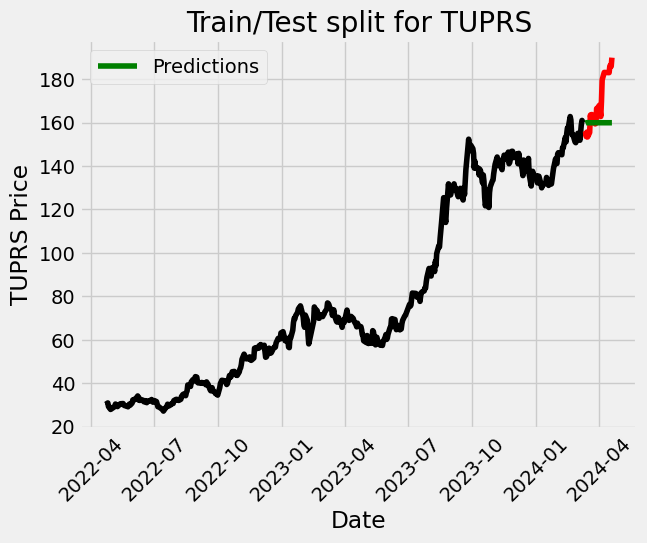

In [ ]:
# Forecast
y_pred2 = results2.get_forecast(len(test.index))
y_pred_df2 = y_pred2.conf_int(alpha = 0.05)
y_pred_df2["Predictions"] = results2.predict(start = y_pred_df2.index[0], end = y_pred_df2.index[-1])
y_pred_df2.index = test.index
y_pred_out2 = y_pred_df2["Predictions"]

# Plot combined
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('TUPRS Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for TUPRS")
plt.plot(y_pred_out2, color='green', label = 'Predictions')
plt.legend()
plt.show()

# Forecast performance
mae2=abs(test-y_pred_out2).mean()
mape2=100*(abs(test-y_pred_out2)/test).mean()
rmse2 = np.mean((y_pred_out2 - test)**2)**.5

## Model 3

In [ ]:
# MA(1)) model
mod3 = sm.tsa.statespace.SARIMAX(y, order = (0, 1, 1))
results3 = mod3.fit(disp=False)
print(results3.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               adjclose   No. Observations:                  471
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1099.068
Date:                Wed, 24 Apr 2024   AIC                           2202.136
Time:                        15:47:01   BIC                           2210.441
Sample:                             0   HQIC                          2205.403
                                - 471                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0642      0.032      1.976      0.048       0.001       0.128
sigma2         6.2902      0.257     24.464      0.000       5.786       6.794
Ljung-Box (L1) (Q):                   0.25   Jarque-

2202.135621759829
2210.4410871492373


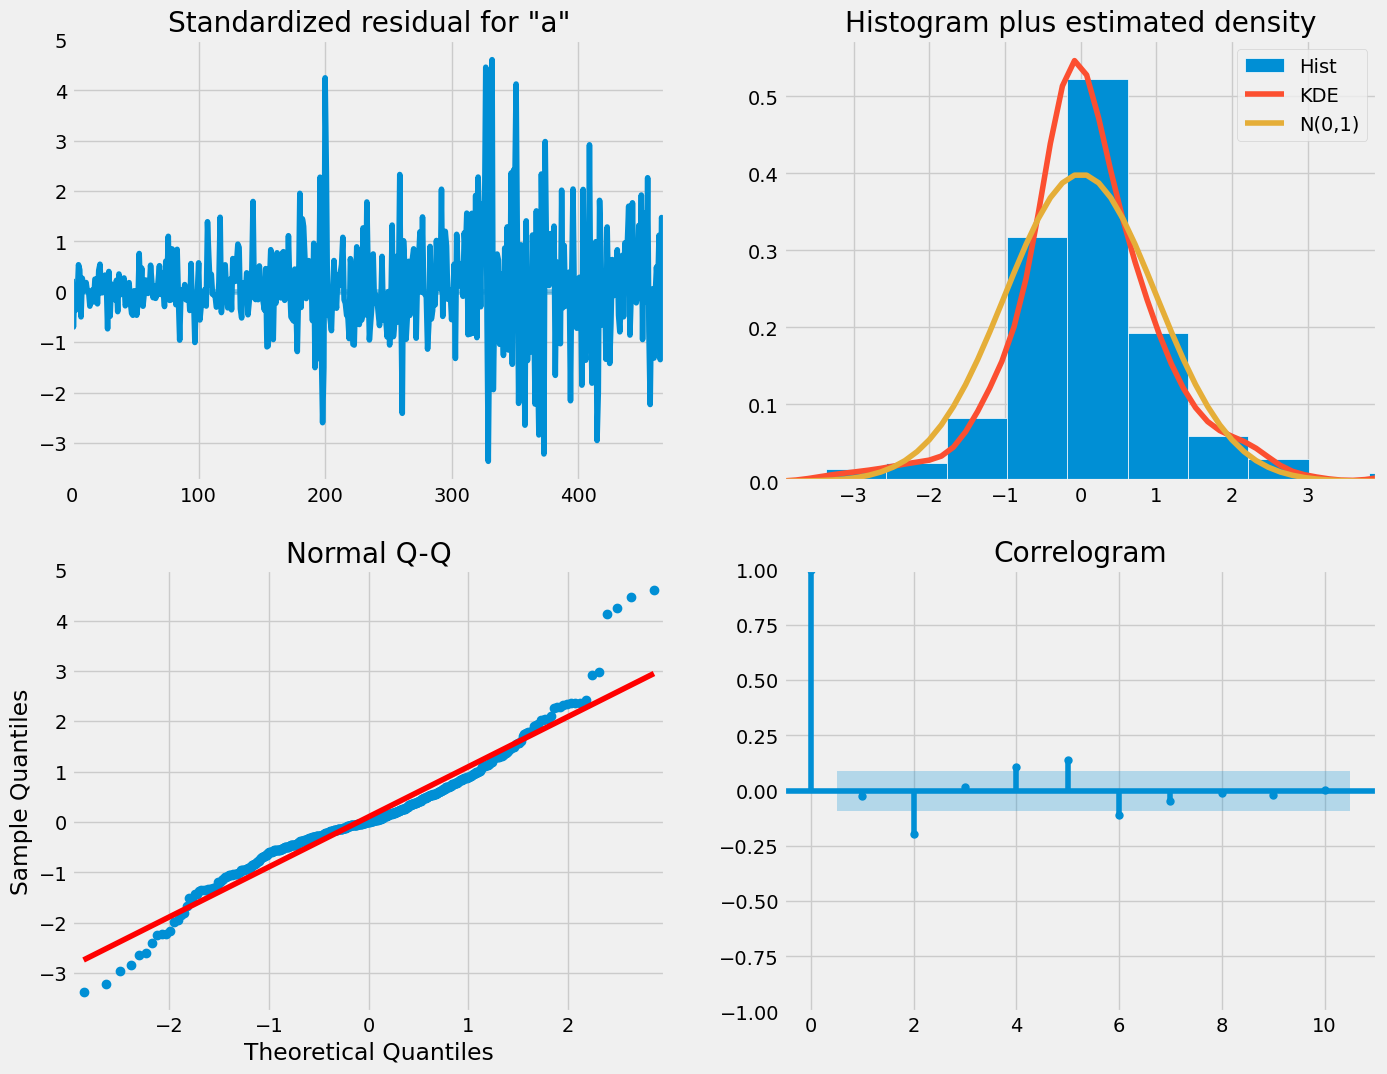

In [ ]:
# Residuals diagnostic
residuals3=results3.resid
results3.plot_diagnostics(figsize=(15,12))

# Information criterias
mod_aic3 = results3.aic
print(mod_aic3)
mod_bic3 = results3.bic
print(mod_bic3)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


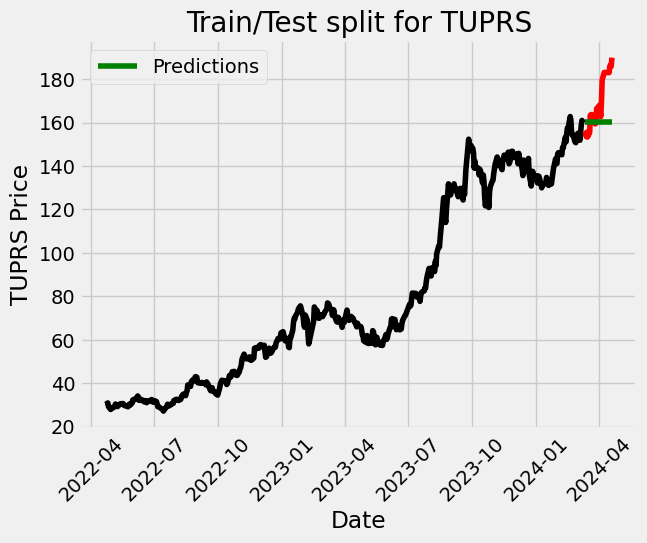

In [ ]:
# Forecast
y_pred3 = results3.get_forecast(len(test.index))
y_pred_df3 = y_pred3.conf_int(alpha = 0.05)
y_pred_df3["Predictions"] = results3.predict(start = y_pred_df3.index[0], end = y_pred_df3.index[-1])
y_pred_df3.index = test.index
y_pred_out3 = y_pred_df3["Predictions"]

# Plot combined
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('TUPRS Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for TUPRS")
plt.plot(y_pred_out3, color='green', label = 'Predictions')
plt.legend()
plt.show()


# Forecast performance
mae3=abs(test-y_pred_out3).mean()
mape3=100*(abs(test-y_pred_out3)/test).mean()
rmse3 = np.mean((y_pred_out3 - test)**2)**.5

## Model 4

In [ ]:
# ARIMA(1,1,1) model
mod4 = sm.tsa.statespace.SARIMAX(y, order = (1, 1, 1))
results4 = mod4.fit(disp=False)
print(results4.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               adjclose   No. Observations:                  471
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1093.692
Date:                Wed, 24 Apr 2024   AIC                           2193.384
Time:                        15:47:05   BIC                           2205.842
Sample:                             0   HQIC                          2198.286
                                - 471                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7398      0.081     -9.129      0.000      -0.899      -0.581
ma.L1          0.8484      0.066     12.815      0.000       0.719       0.978
sigma2         6.1469      0.254     24.208      0.0

2193.3842657952537
2205.842463879366


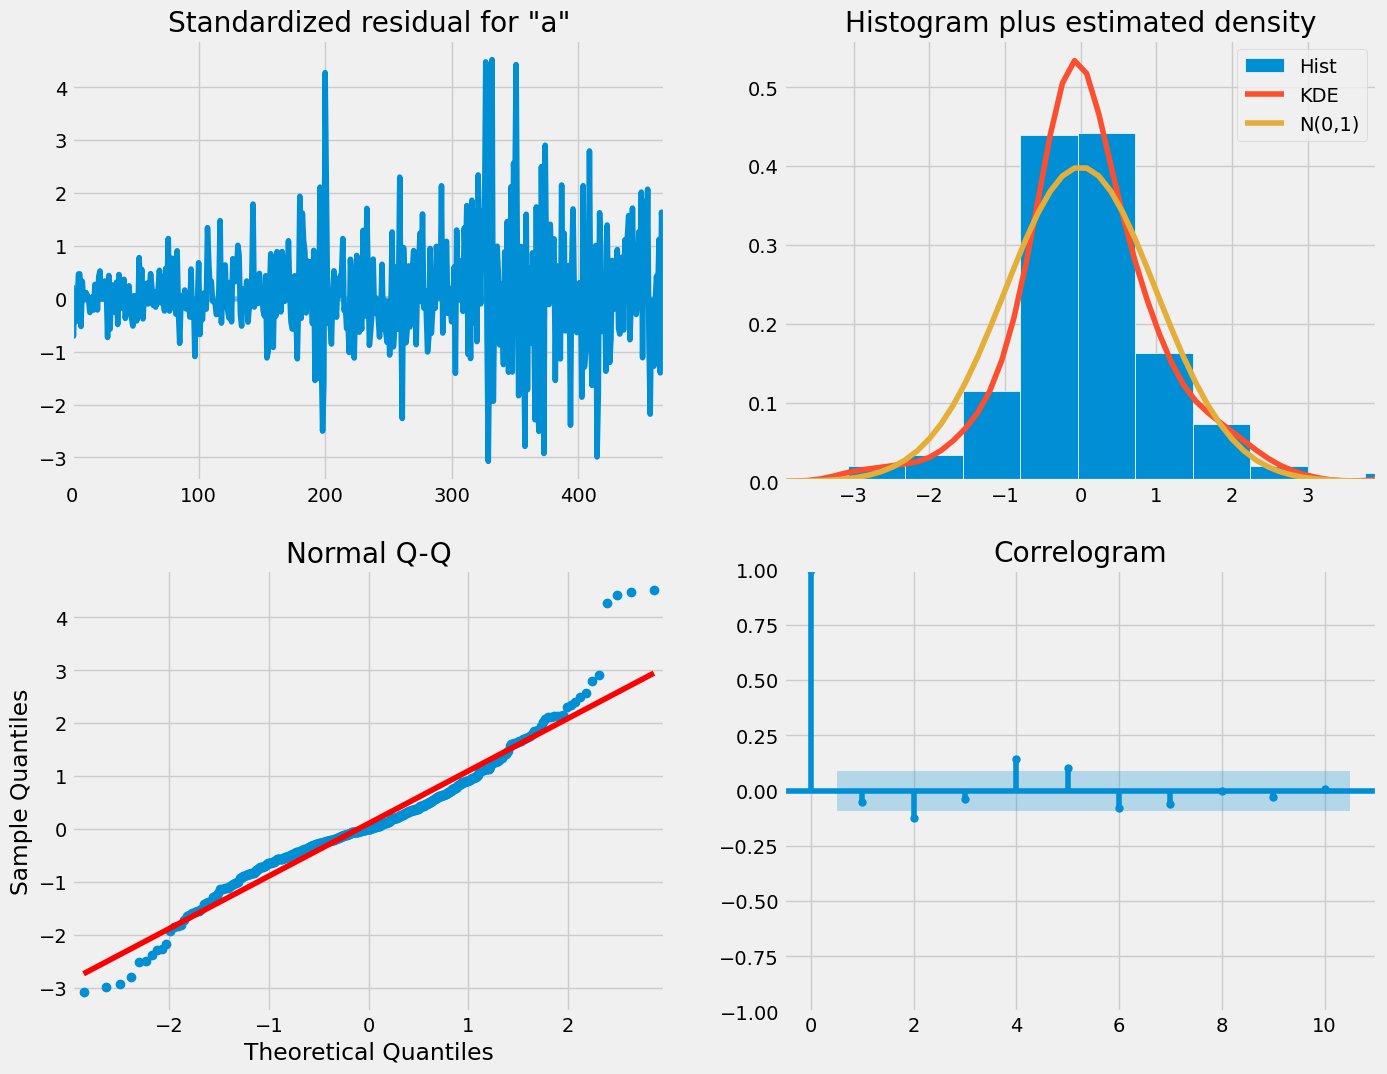

In [ ]:
#Residuals diagnostic
residuals4=results4.resid
results4.plot_diagnostics(figsize=(15,12))

#Information criterias
mod_aic4 = results4.aic
print(mod_aic4)
mod_bic4 = results4.bic
print(mod_bic4)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


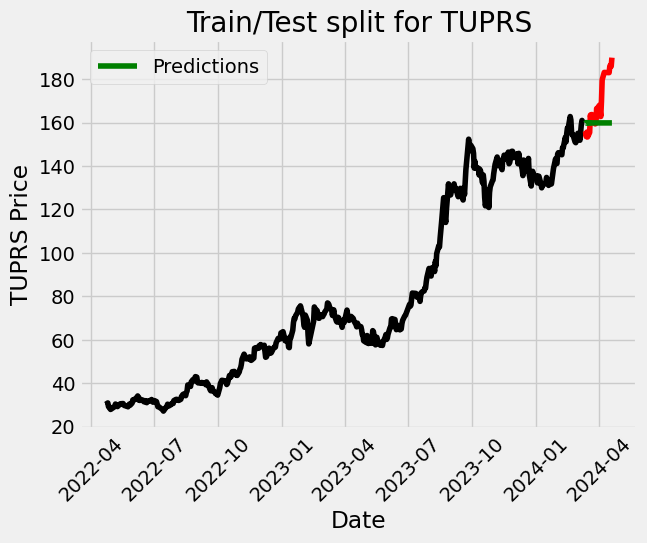

In [ ]:
# Forecast
y_pred4 = results4.get_forecast(len(test.index))
y_pred_df4 = y_pred4.conf_int(alpha = 0.05)
y_pred_df4["Predictions"] = results4.predict(start = y_pred_df4.index[0], end = y_pred_df4.index[-1])
y_pred_df4.index = test.index
y_pred_out4 = y_pred_df4["Predictions"]

# Plot combined
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('TUPRS Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for TUPRS")
plt.plot(y_pred_out4, color='green', label = 'Predictions')
plt.legend()
plt.show()


# Forecast performance
mae4=abs(test-y_pred_out4).mean()
mape4=100*(abs(test-y_pred_out4)/test).mean()
rmse4 = np.mean((y_pred_out4 - test)**2)**.5

## Model 5

In [ ]:
# ARIMA(2,1,2) model
mod5 = sm.tsa.statespace.SARIMAX(y, order = (2, 1, 2))
results5 = mod5.fit(disp=False)
print(results5.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               adjclose   No. Observations:                  471
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1087.575
Date:                Wed, 24 Apr 2024   AIC                           2185.151
Time:                        15:47:10   BIC                           2205.914
Sample:                             0   HQIC                          2193.320
                                - 471                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1236      0.094      1.314      0.189      -0.061       0.308
ar.L2         -0.7531      0.097     -7.725      0.000      -0.944      -0.562
ma.L1         -0.0920      0.111     -0.825      0.4

2185.1508038916472
2205.9144673651676


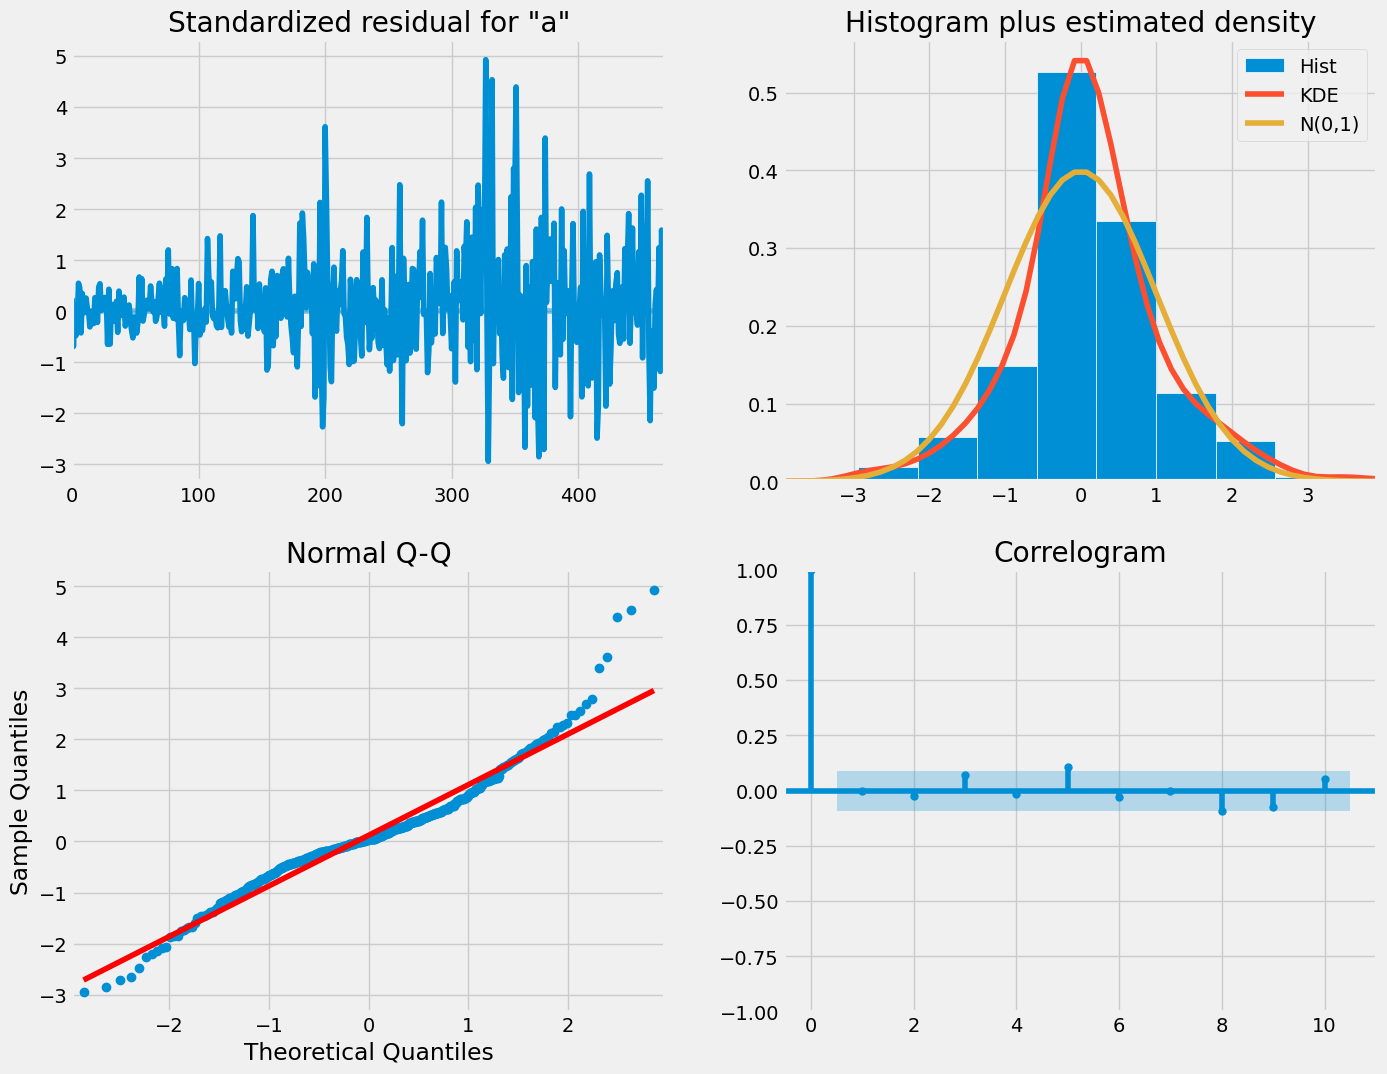

In [ ]:
# Residuals diagnostic
residuals5=results5.resid
results5.plot_diagnostics(figsize=(15,12))

# Information criterias
mod_aic5 = results5.aic
print(mod_aic5)
mod_bic5 = results5.bic
print(mod_bic5)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


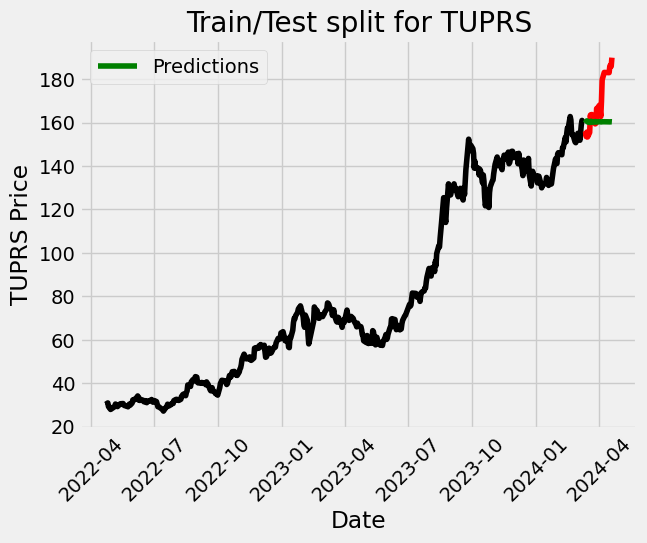

In [ ]:
# Forecast performance
y_pred5 = results5.get_forecast(len(test.index))
y_pred_df5 = y_pred5.conf_int(alpha = 0.05)
y_pred_df5["Predictions"] = results5.predict(start = y_pred_df5.index[0], end = y_pred_df5.index[-1])
y_pred_df5.index = test.index
y_pred_out5 = y_pred_df5["Predictions"]

# Plot combined
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('TUPRS Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for TUPRS")
plt.plot(y_pred_out5, color='green', label = 'Predictions')
plt.legend()
plt.show()


# Forecast performance
mae5=abs(test-y_pred_out5).mean()
mape5=100*(abs(test-y_pred_out5)/test).mean()
rmse5 = np.mean((y_pred_out5 - test)**2)**.5

## Model 6

In [ ]:
# ARIMA(3,1,2) model
mod6 = sm.tsa.statespace.SARIMAX(y, order = (3, 1, 2))
results6 = mod6.fit(disp=False)
print(results6.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:               adjclose   No. Observations:                  471
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -1083.805
Date:                Wed, 24 Apr 2024   AIC                           2179.610
Time:                        15:47:14   BIC                           2204.526
Sample:                             0   HQIC                          2189.413
                                - 471                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0497      0.105     10.024      0.000       0.844       1.255
ar.L2         -0.7677      0.101     -7.632      0.000      -0.965      -0.571
ar.L3          0.2232      0.041      5.453      0.0

2179.610103429178
2204.5264995974026


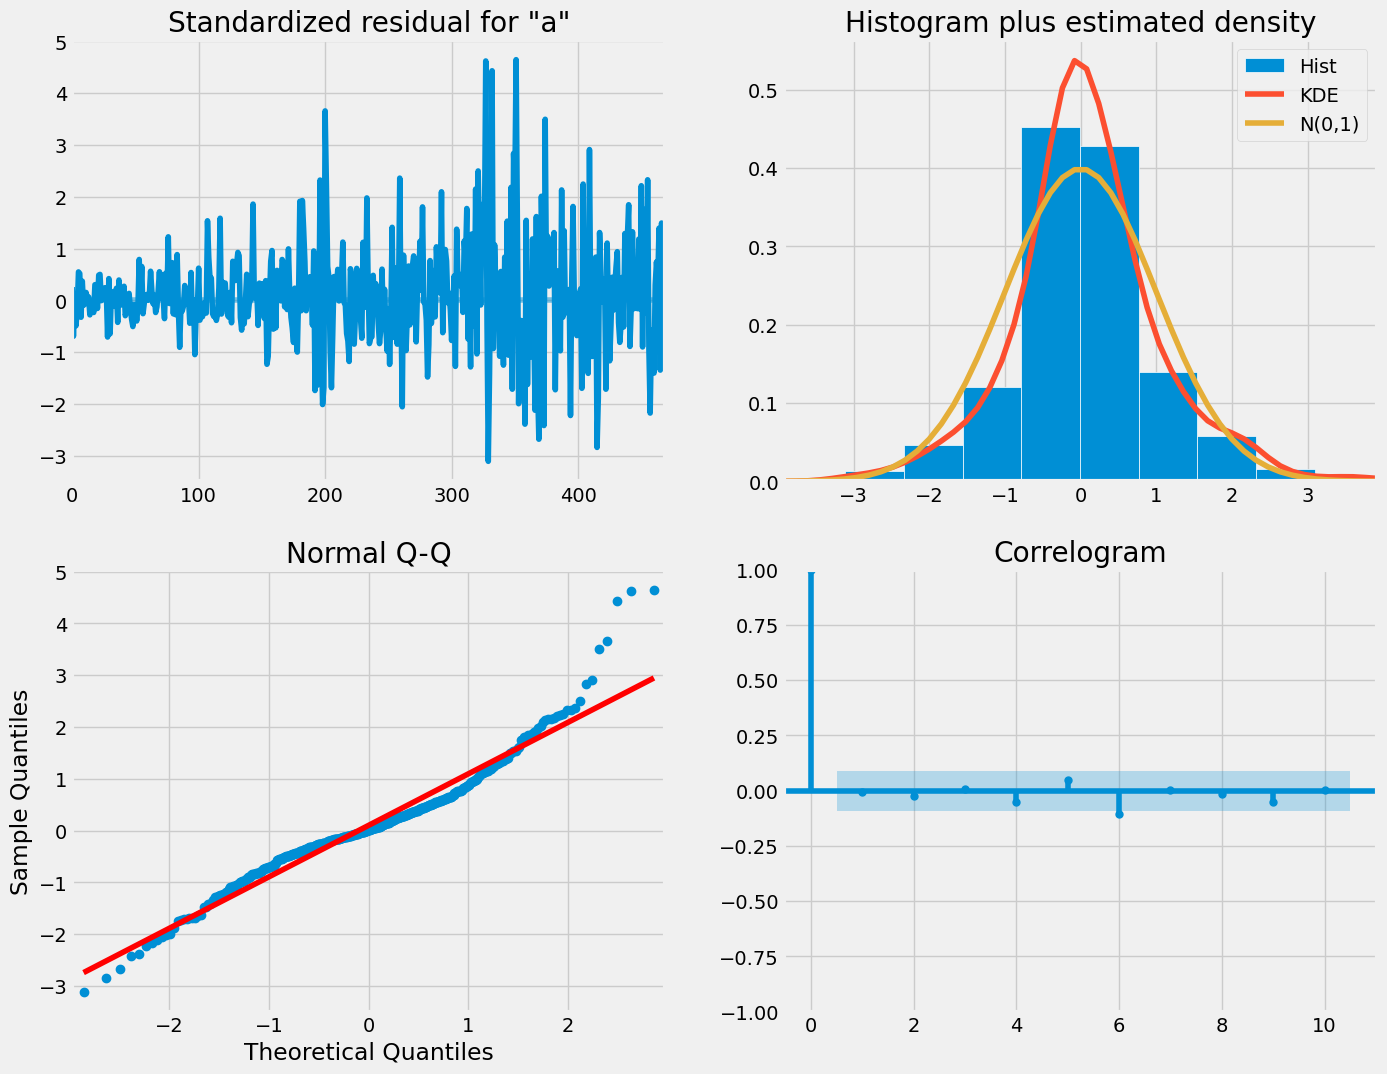

In [ ]:
# Residuals diagnostic
residuals6=results6.resid
results6.plot_diagnostics(figsize=(15,12))

# Information criterias
mod_aic6 = results6.aic
print(mod_aic6)
mod_bic6 = results6.bic
print(mod_bic6)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


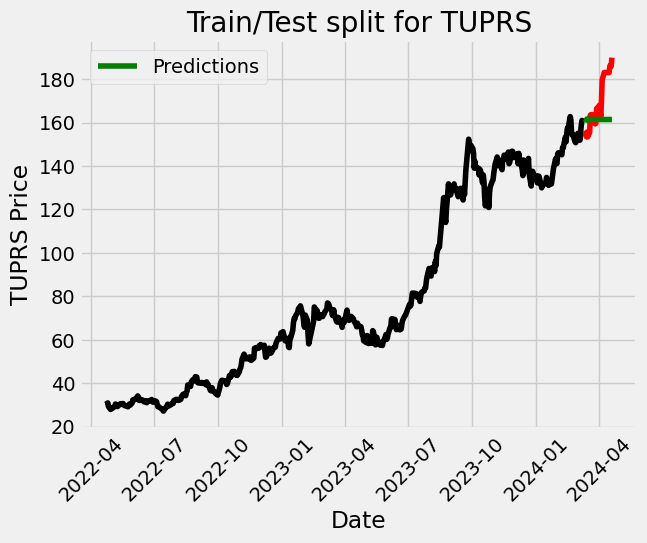

In [ ]:
# Forecast
y_pred6 = results6.get_forecast(len(test.index))
y_pred_df6 = y_pred6.conf_int(alpha = 0.05)
y_pred_df6["Predictions"] = results6.predict(start = y_pred_df6.index[0], end = y_pred_df6.index[-1])
y_pred_df6.index = test.index
y_pred_out6 = y_pred_df6["Predictions"]

# Plot combined
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('TUPRS Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for TUPRS")
plt.plot(y_pred_out6, color='green', label = 'Predictions')
plt.legend()
plt.show()

# Forecast performance
mae6=abs(test-y_pred_out6).mean()
mape6=100*(abs(test-y_pred_out6)/test).mean()
rmse6 = np.mean((y_pred_out6 - test)**2)**.5

# Choice of the model

We repeated different estimates for different models, performing a diagnostic of each model and evaluating its predictive capacity for in-saple forecast.

As for the predictive performance of the model, we see that the best model, that is the one that has lower errors, is the first: AR(1).

Specifically the AR(1) model has:

- Mean Absolute Error (MAE) =  7.71

- Mean Absolute Percentage Error (MAPE) = 4.38

- Root Mean Square Error (RMSE) = 10.54


In [ ]:
print("Mean Absolute Error")
print(mae1, mae2, mae3, mae4, mae5, mae6)
print("Mean Absolute Percentage Error")
print(mape1, mape2, mape3, mape4, mape5, mape6)
print("Root Mean Square Error")
print(rmse, rmse2, rmse3, rmse4, rmse5, rmse6)

Mean Absolute Error
7.71176736071138 10.050814706933696 9.999311251955538 10.085626495421572 9.891600675273425 9.475570288192092
Mean Absolute Percentage Error
4.382045807574734 5.663001196053807 5.636538331544308 5.68215148212466 5.5785573035461775 5.3552266844032355
Root Mean Square Error
10.543774853236066 13.965516763818954 13.878612615403998 14.01217983194842 13.725701458245268 13.159218576236322


# Out-of-Sample Forecast

In [ ]:
# Real out of sample predictions
tpred_real=results.get_prediction(start=len(data),end=len(data)+len(test),dynamic=True)
pred_ci=tpred_real.conf_int()
pred_real=tpred_real.predicted_mean
pred_real=pred_real.reset_index()
del pred_real['index']
pred_real.columns = ['real predicted']

print(pred_real)

    real predicted
0       167.577865
1       167.854168
2       168.130471
3       168.406774
4       168.683077
5       168.959379
6       169.235682
7       169.511985
8       169.788288
9       170.064591
10      170.340893
11      170.617196
12      170.893499
13      171.169802
14      171.446105
15      171.722407
16      171.998710
17      172.275013
18      172.551316
19      172.827619
20      173.103922
21      173.380224
22      173.656527
23      173.932830
24      174.209133
25      174.485436


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
